# 2b. ERROR DETECTION AND CORRECTION

This notebook handles:
1. **Address Consistency Check & Repair** - Verify and repair the Indirizzo field
2. **Missing Values Analysis** - Identify patterns of missing data
3. **Missing Values Imputation** - Fill missing values using domain knowledge and data patterns
4. **Outlier Detection** - Identify potential outliers in numerical columns
5. **Outlier Handling** - Decide on treatment strategies

## 2b.1 Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 140)
%matplotlib inline

In [2]:
# Load the transformed dataset from previous step
# If running independently, load the original
try:
    MILANO = pd.read_csv("MILANO_transformed.csv", sep=";")
    print("Loaded transformed dataset")
except FileNotFoundError:
    MILANO = pd.read_csv("Comune-di-Milano-Pubblici-esercizi(in)-2.csv", sep=";")
    print("Loaded original dataset")

print(f"Shape: {MILANO.shape}")
MILANO.head()

Loaded transformed dataset
Shape: (6904, 14)


,Tipo esercizio storico pubblico esercizio,Insegna,Indirizzo,Tipo via,Nome via,Civico,Codice via,ZD,Forma commercio,Forma commercio precedente,Forma vendita,Settore storico pubblico esercizio,Superficie somministrazione,Tipo_macro
0,NaN,NaN,alz naviglio grande n. 12 ; isolato:057; (z.d. 6),alz,naviglio grande,12,5144,6,NaN,NaN,NaN,"ristorante, trattoria, osteria;genere merceol....",83.0,RISTORANTE
1,NaN,NaN,alz naviglio grande n. 44 (z.d. 6),alz,naviglio grande,44,5144,6,NaN,NaN,NaN,bar gastronomici e simili,26.0,BAR
2,NaN,NaN,alz naviglio grande n. 48 (z.d. 6),alz,naviglio grande,48,5144,6,NaN,NaN,NaN,bar gastronomici e simili,58.0,BAR
3,NaN,NaN,alz naviglio grande n. 8 (z.d. 6),alz,naviglio grande,8,5144,6,NaN,NaN,NaN,"bar caffè e simili;ristorante, trattoria, osteria",101.0,RISTORANTE
4,NaN,NaN,alz naviglio pavese n. 24 (z.d. 6),alz,naviglio pavese,24,5161,6,NaN,NaN,NaN,bar gastronomici e simili,51.0,BAR


---
# 1. ADDRESS CONSISTENCY CHECK & REPAIR

Verify that the free-text `Indirizzo` field is consistent with structured address columns.

In [3]:
import re

# Work with address-related columns
addr_cols = ['Indirizzo', 'Tipo via', 'Nome via', 'Civico', 'Codice via', 'ZD']
ADDR = MILANO[addr_cols].copy()
ADDR.head()

,Indirizzo,Tipo via,Nome via,Civico,Codice via,ZD
0,alz naviglio grande n. 12 ; isolato:057; (z.d. 6),alz,naviglio grande,12,5144,6
1,alz naviglio grande n. 44 (z.d. 6),alz,naviglio grande,44,5144,6
2,alz naviglio grande n. 48 (z.d. 6),alz,naviglio grande,48,5144,6
3,alz naviglio grande n. 8 (z.d. 6),alz,naviglio grande,8,5144,6
4,alz naviglio pavese n. 24 (z.d. 6),alz,naviglio pavese,24,5161,6


## 1.1 Extract Components from Indirizzo

In [4]:
# Regex patterns to extract components
REGEX_TIPO = r"^(.{3})"  # First 3 characters
REGEX_DESC = r"^.{3}\s+(.*?)\s+\b(?:N\.?|num\.)\b"  # Street name until N./num.
REGEX_CIV = r"\b(?:N\.?|num\.)\s*0*([0-9]+)"  # Civic number
REGEX_ZD = r"z\.d\.\s*(\d+)"  # Zone code

ADDR['ubi_tipo'] = ADDR['Indirizzo'].str.extract(REGEX_TIPO, expand=False)
ADDR['ubi_desc'] = ADDR['Indirizzo'].str.extract(REGEX_DESC, expand=False, flags=re.IGNORECASE)
ADDR['ubi_civico'] = ADDR['Indirizzo'].str.extract(REGEX_CIV, expand=False, flags=re.IGNORECASE)
ADDR['ubi_zd'] = ADDR['Indirizzo'].str.extract(REGEX_ZD, expand=False, flags=re.IGNORECASE)

ADDR[['Indirizzo', 'ubi_tipo', 'ubi_desc', 'ubi_civico', 'ubi_zd']].head(10)

,Indirizzo,ubi_tipo,ubi_desc,ubi_civico,ubi_zd
0,alz naviglio grande n. 12 ; isolato:057; (z.d. 6),alz,naviglio grande,12,6
1,alz naviglio grande n. 44 (z.d. 6),alz,naviglio grande,44,6
2,alz naviglio grande n. 48 (z.d. 6),alz,naviglio grande,48,6
3,alz naviglio grande n. 8 (z.d. 6),alz,naviglio grande,8,6
4,alz naviglio pavese n. 24 (z.d. 6),alz,naviglio pavese,24,6
5,alz naviglio pavese n. 6 (z.d. 6),alz,naviglio pavese,6,6
6,bst di porta nuova n. 10 con ingr.su piazza xx...,bst,di porta nuova,10,1
7,bst di porta volta n. 9 (z.d. 1),bst,di porta volta,9,1
8,bst di porta volta n. 9 (z.d. 1),bst,di porta volta,9,1
9,bst di porta volta num.018/a ; (z.d. 1),bst,di porta volta,18,1


## 1.2 Compare Extracted vs Structured Values

In [5]:
# Build match flags
ADDR['Tipo_match'] = ADDR['ubi_tipo'] == ADDR['Tipo via']
ADDR['Descrizione_match'] = ADDR['ubi_desc'] == ADDR['Nome via']
ADDR['Civico_match'] = ADDR['ubi_civico'].astype(str) == ADDR['Civico'].astype(str)
ADDR['ZD_match'] = ADDR['ubi_zd'].astype(str) == ADDR['ZD'].astype(str)

# Summary
summary = pd.Series({
    'Total rows': len(ADDR),
    'Tipo mismatches': (~ADDR['Tipo_match']).sum(),
    'Descrizione mismatches': (~ADDR['Descrizione_match']).sum(),
    'Civico mismatches': (~ADDR['Civico_match']).sum(),
    'ZD mismatches': (~ADDR['ZD_match']).sum(),
})
summary

Total rows                6904
Tipo mismatches             56
Descrizione mismatches     108
Civico mismatches          268
ZD mismatches               31
dtype: int64

## 1.3 Selective Repair of Indirizzo

In [6]:
# Rebuild Indirizzo from structured fields for rows with street name mismatch
ubi_rebuilt = (
    ADDR['Tipo via'].astype(str).str.strip() + ' ' +
    ADDR['Nome via'].astype(str).str.strip() + ' n. ' +
    ADDR['Civico'].astype(str).str.strip() + ' ' +
    '(z.d. ' + ADDR['ZD'].astype(str) + ')'
).str.replace(r"\s+", " ", regex=True).str.strip()

# Create clean Indirizzo column
ADDR['Indirizzo_clean'] = ADDR['Indirizzo']

# Only repair rows where street name doesn't match
mask_rebuild = ~ADDR['Descrizione_match']
ADDR.loc[mask_rebuild, 'Indirizzo_clean'] = ubi_rebuilt.loc[mask_rebuild]

print(f"Repaired {mask_rebuild.sum()} rows")

Repaired 108 rows


In [7]:
# Validate repairs
ADDR['ubi_desc2'] = ADDR['Indirizzo_clean'].str.extract(REGEX_DESC, expand=False, flags=re.IGNORECASE)
ADDR['Descrizione_match_after'] = ADDR['ubi_desc2'] == ADDR['Nome via']

before = (~ADDR['Descrizione_match']).sum()
after = (~ADDR['Descrizione_match_after']).sum()

print(f"Descrizione mismatches BEFORE: {before}")
print(f"Descrizione mismatches AFTER: {after}")

Descrizione mismatches BEFORE: 108
Descrizione mismatches AFTER: 1


In [8]:
# Apply clean Indirizzo back to main dataframe
MILANO['Indirizzo'] = ADDR['Indirizzo_clean']
print("Applied cleaned Indirizzo to main dataframe")

Applied cleaned Indirizzo to main dataframe


---
# 2. MISSING VALUES ANALYSIS

## 2.1 Overview of Missing Values

In [9]:
# Count missing values per column
null_counts = MILANO.isnull().sum()
null_pct = (null_counts / len(MILANO) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': null_counts.index,
    'Missing Count': null_counts.values,
    'Missing %': null_pct.values
}).sort_values('Missing %', ascending=False)

missing_df[missing_df['Missing Count'] > 0]

,Column,Missing Count,Missing %
1,Insegna,3410,49.39
8,Forma commercio,1571,22.75
10,Forma vendita,1424,20.63
9,Forma commercio precedente,1397,20.23
0,Tipo esercizio storico pubblico esercizio,1353,19.60
5,Civico,156,2.26
12,Superficie somministrazione,79,1.14
11,Settore storico pubblico esercizio,21,0.30


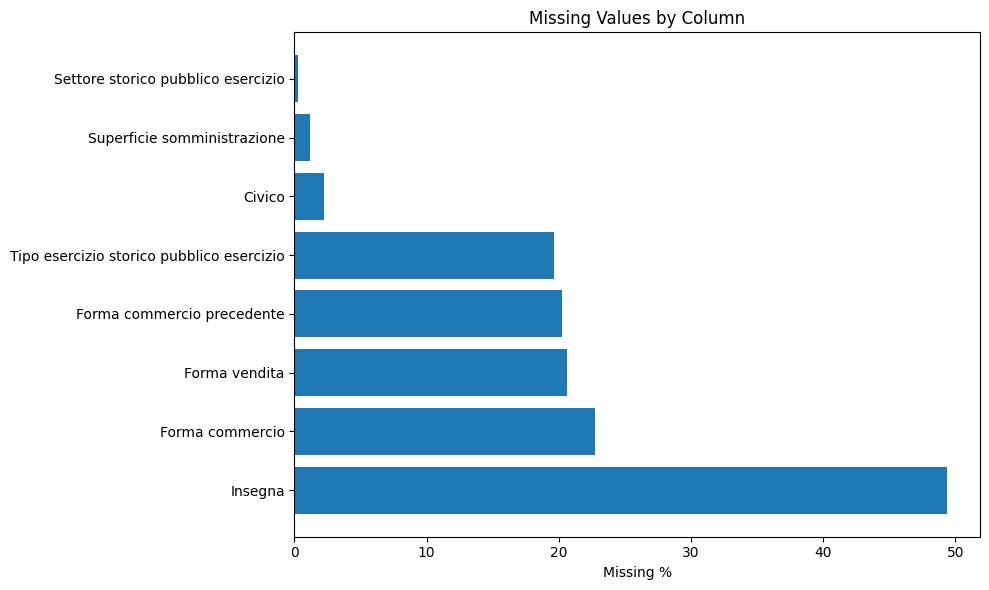

In [10]:
# Visualize missing values
missing_cols = missing_df[missing_df['Missing Count'] > 0]['Column'].tolist()

if missing_cols:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_df[missing_df['Missing Count'] > 0]['Column'], 
             missing_df[missing_df['Missing Count'] > 0]['Missing %'])
    plt.xlabel('Missing %')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.show()

---
# 3. MISSING VALUES IMPUTATION

## 3.1 Fill Missing Civico from Indirizzo

In [11]:
# Check for null Civico
print(f"Null Civico before: {MILANO['Civico'].isna().sum()}")

# Fill from extracted ubi_civico where Civico is null
mask_fill_civico = MILANO['Civico'].isna() & ADDR['ubi_civico'].notna()
MILANO.loc[mask_fill_civico, 'Civico'] = ADDR.loc[mask_fill_civico, 'ubi_civico']

print(f"Null Civico after: {MILANO['Civico'].isna().sum()}")

Null Civico before: 156
Null Civico after: 0


## 3.2 Handle 'Insegna' (Business Name)

The `Insegna` column has ~50% missing values. Since we cannot infer business names, we fill with "Unknown".

In [12]:
if 'Insegna' in MILANO.columns:
    print(f"Insegna - Missing before: {MILANO['Insegna'].isna().sum()}")
    MILANO['Insegna'] = MILANO['Insegna'].fillna('unknown')
    print(f"Insegna - Missing after: {MILANO['Insegna'].isna().sum()}")

Insegna - Missing before: 3410
Insegna - Missing after: 0


## 3.2 Handle 'Superficie somministrazione' with KNN Imputation

Fill missing surface values using the mean of nearby establishments (same street or same zone).

In [13]:
sup_col = 'Superficie somministrazione'
via_col = 'Codice via'
zd_col = 'ZD'

if sup_col in MILANO.columns:
    # Ensure numeric
    MILANO[sup_col] = pd.to_numeric(MILANO[sup_col], errors='coerce')
    
    # Track original missing indices
    original_missing = MILANO[sup_col].isna()
    missing_before = original_missing.sum()
    print(f"{sup_col} - Missing before: {missing_before}")
    
    # Create lists to track filled values
    filled_records = []
    
    # Strategy 1: Mean of establishments on the same street (Codice via)
    if via_col in MILANO.columns:
        via_means = MILANO.groupby(via_col)[sup_col].transform('mean')
        mask_via = MILANO[sup_col].isna() & via_means.notna()
        MILANO.loc[mask_via, sup_col] = via_means[mask_via]
        filled_via = mask_via.sum()
        print(f"  - Filled {filled_via} using same street mean (Codice via)")
        
        # Track filled values
        for idx in MILANO[mask_via].index:
            filled_records.append({
                'Index': idx,
                'Strategy': 'Same Street',
                'Codice via': MILANO.loc[idx, via_col],
                'ZD': MILANO.loc[idx, zd_col] if zd_col in MILANO.columns else None,
                'Filled Value': MILANO.loc[idx, sup_col]
            })
    
    # Strategy 2: Mean of establishments in the same zone (ZD) - fallback
    if zd_col in MILANO.columns:
        zd_means = MILANO.groupby(zd_col)[sup_col].transform('mean')
        mask_zd = MILANO[sup_col].isna() & zd_means.notna()
        MILANO.loc[mask_zd, sup_col] = zd_means[mask_zd]
        filled_zd = mask_zd.sum()
        print(f"  - Filled {filled_zd} using same zone mean (ZD)")
        
        # Track filled values
        for idx in MILANO[mask_zd].index:
            filled_records.append({
                'Index': idx,
                'Strategy': 'Same Zone',
                'Codice via': MILANO.loc[idx, via_col] if via_col in MILANO.columns else None,
                'ZD': MILANO.loc[idx, zd_col],
                'Filled Value': MILANO.loc[idx, sup_col]
            })
    
    # Strategy 3: Global mean - final fallback for remaining NaN
    remaining_na = MILANO[sup_col].isna().sum()
    if remaining_na > 0:
        global_mean = MILANO[sup_col].mean()
        mask_global = MILANO[sup_col].isna()
        MILANO[sup_col] = MILANO[sup_col].fillna(global_mean)
        print(f"  - Filled {remaining_na} using global mean: {global_mean:.2f}")
        
        # Track filled values
        for idx in MILANO[mask_global].index:
            filled_records.append({
                'Index': idx,
                'Strategy': 'Global Mean',
                'Codice via': MILANO.loc[idx, via_col] if via_col in MILANO.columns else None,
                'ZD': MILANO.loc[idx, zd_col] if zd_col in MILANO.columns else None,
                'Filled Value': global_mean
            })
    
    print(f"{sup_col} - Missing after: {MILANO[sup_col].isna().sum()}")
    
    # Display filled values
    if filled_records:
        filled_df = pd.DataFrame(filled_records)
        print(f"\n=== FILLED VALUES ({len(filled_df)} rows) ===")
        display(filled_df)

Superficie somministrazione - Missing before: 79
  - Filled 73 using same street mean (Codice via)
  - Filled 6 using same zone mean (ZD)
Superficie somministrazione - Missing after: 0

=== FILLED VALUES (79 rows) ===


,Index,Strategy,Codice via,ZD,Filled Value
0,33,Same Street,300,1,149.800000
1,44,Same Street,1010,1,72.354839
2,75,Same Street,303,1,243.500000
3,99,Same Street,3101,4,101.700000
4,117,Same Street,1,1,245.400000
...,...,...,...,...,...
74,318,Same Zone,1193,2,89.387466
75,564,Same Zone,4163,5,90.170577
76,789,Same Zone,3236,3,73.551145
77,1107,Same Zone,2212,3,73.551145


## 3.4 Handle 'Forma commercio prev' using Macro-Category

We use the relationship between macro-categories and commerce forms to impute missing values, but only when confidence is >= 80%.

In [14]:
prev_col = 'Forma commercio precedente'
macro_col = 'Tipo_macro' if 'Tipo_macro' in MILANO.columns else None
soglia = 0.80

if prev_col in MILANO.columns and macro_col:
    # Normalize values
    MILANO[prev_col] = MILANO[prev_col].astype(str).str.strip().str.lower().replace('nan', np.nan)
    MILANO[macro_col] = MILANO[macro_col].astype(str).str.strip().str.upper().replace('nan', np.nan)
    
    # Build mapping: macro -> dominant prev value + confidence
    tmp = MILANO[[macro_col, prev_col]].dropna(subset=[macro_col, prev_col]).copy()
    
    counts = (
        tmp.groupby([macro_col, prev_col])
           .size()
           .rename('n')
           .reset_index()
    )
    
    tot = counts.groupby(macro_col)['n'].sum().rename('tot').reset_index()
    counts = counts.merge(tot, on=macro_col, how='left')
    counts['conf'] = counts['n'] / counts['tot']
    
    best = (
        counts.sort_values(['conf', 'n'], ascending=False)
              .drop_duplicates(subset=[macro_col])
              [[macro_col, prev_col, 'n', 'tot', 'conf']]
              .sort_values('conf', ascending=False)
    )
    
    print(f"Macro-categories with confidence >= {soglia}:")
    display(best[best['conf'] >= soglia])
    
    # Imputation
    mode_map = dict(zip(best[macro_col], best[prev_col]))
    conf_map = dict(zip(best[macro_col], best['conf']))
    
    prev_na_before = MILANO[prev_col].isna().sum()
    
    MILANO['_prev_mode'] = MILANO[macro_col].map(mode_map)
    MILANO['_prev_conf'] = MILANO[macro_col].map(conf_map)
    
    mask_fill = MILANO[prev_col].isna() & (MILANO['_prev_conf'] >= soglia)
    
    # Track filled values before applying
    filled_records = []
    for idx in MILANO[mask_fill].index:
        filled_records.append({
            'Index': idx,
            'Tipo_macro': MILANO.loc[idx, macro_col],
            'Filled Value': MILANO.loc[idx, '_prev_mode'],
            'Confidence': MILANO.loc[idx, '_prev_conf']
        })
    
    MILANO.loc[mask_fill, prev_col] = MILANO.loc[mask_fill, '_prev_mode']
    
    prev_na_after = MILANO[prev_col].isna().sum()
    
    # Cleanup
    MILANO = MILANO.drop(columns=['_prev_mode', '_prev_conf'])
    
    print(f"\n{prev_col} - Missing before: {prev_na_before}")
    print(f"{prev_col} - Imputed rows: {mask_fill.sum()}")
    print(f"{prev_col} - Missing after: {prev_na_after}")
    
    # Display filled values
    if filled_records:
        filled_df = pd.DataFrame(filled_records)
        print(f"\n=== FILLED VALUES ({len(filled_df)} rows) ===")
        display(filled_df)

Macro-categories with confidence >= 0.8:


,Tipo_macro,Forma commercio precedente,n,tot,conf
11,RISTORANTE,somministrazione,2273,2287,0.993878
9,PIZZERIA,somministrazione,174,177,0.983051
3,BAR,somministrazione,2912,3012,0.966799
5,GASTRONOMIA,somministrazione,22,23,0.956522
1,ALTRO,somministrazione,5,6,0.833333



Forma commercio precedente - Missing before: 1397
Forma commercio precedente - Imputed rows: 1396
Forma commercio precedente - Missing after: 1

=== FILLED VALUES (1396 rows) ===


,Index,Tipo_macro,Filled Value,Confidence
0,0,RISTORANTE,somministrazione,0.993878
1,1,BAR,somministrazione,0.966799
2,2,BAR,somministrazione,0.966799
3,3,RISTORANTE,somministrazione,0.993878
4,4,BAR,somministrazione,0.966799
...,...,...,...,...
1391,6233,RISTORANTE,somministrazione,0.993878
1392,6467,RISTORANTE,somministrazione,0.993878
1393,6567,RISTORANTE,somministrazione,0.993878
1394,6590,RISTORANTE,somministrazione,0.993878


## 3.4 Handle 'Forma commercio' using 'Forma commercio prev'

In [15]:
new_col = 'Forma commercio'
prev_col = 'Forma commercio precedente'

if new_col in MILANO.columns and prev_col in MILANO.columns:
    # Normalize
    MILANO[new_col] = MILANO[new_col].astype(str).str.strip().str.lower().replace('nan', np.nan)
    MILANO[prev_col] = MILANO[prev_col].astype(str).str.strip().str.lower().replace('nan', np.nan)
    
    # Build mapping: prev -> new dominant value
    dist = pd.crosstab(MILANO[prev_col], MILANO[new_col], normalize='index')
    new_mode = dist.idxmax(axis=1)
    conf = dist.max(axis=1)
    
    print("Mapping prev -> new (with confidence):")
    display(pd.DataFrame({'mode': new_mode, 'confidence': conf}))
    
    # Impute only where new is NaN, prev is known, and conf >= threshold
    mask_fill = (
        MILANO[new_col].isna() &
        MILANO[prev_col].notna() &
        (MILANO[prev_col].map(conf) >= soglia)
    )
    
    # Track filled values before applying
    filled_records = []
    for idx in MILANO[mask_fill].index:
        prev_val = MILANO.loc[idx, prev_col]
        filled_records.append({
            'Index': idx,
            'Forma commercio prev': prev_val,
            'Filled Value': new_mode.get(prev_val, None),
            'Confidence': conf.get(prev_val, None)
        })
    
    new_na_before = MILANO[new_col].isna().sum()
    MILANO.loc[mask_fill, new_col] = MILANO.loc[mask_fill, prev_col].map(new_mode)
    new_na_after = MILANO[new_col].isna().sum()
    
    print(f"\n{new_col} - Missing before: {new_na_before}")
    print(f"{new_col} - Imputed rows: {mask_fill.sum()}")
    print(f"{new_col} - Missing after: {new_na_after}")
    
    # Display filled values
    if filled_records:
        filled_df = pd.DataFrame(filled_records)
        print(f"\n=== FILLED VALUES ({len(filled_df)} rows) ===")
        display(filled_df)

Mapping prev -> new (with confidence):


,mode,confidence
Forma commercio precedente,,
minuto,somministrazione/minuto,0.891667
somministrazione,solo somministrazione,0.911184



Forma commercio - Missing before: 1571
Forma commercio - Imputed rows: 1570
Forma commercio - Missing after: 1

=== FILLED VALUES (1570 rows) ===


,Index,Forma commercio prev,Filled Value,Confidence
0,0,somministrazione,solo somministrazione,0.911184
1,1,somministrazione,solo somministrazione,0.911184
2,2,somministrazione,solo somministrazione,0.911184
3,3,somministrazione,solo somministrazione,0.911184
4,4,somministrazione,solo somministrazione,0.911184
...,...,...,...,...
1565,6748,somministrazione,solo somministrazione,0.911184
1566,6749,somministrazione,solo somministrazione,0.911184
1567,6817,somministrazione,solo somministrazione,0.911184
1568,6866,somministrazione,solo somministrazione,0.911184


## 3.5 Handle 'Forma vendita'

Since there's no strong deterministic relationship, we treat missing as a valid category.

In [16]:
vend_col = 'Forma vendita'

if vend_col in MILANO.columns:
    print(f"{vend_col} - Missing before: {MILANO[vend_col].isna().sum()}")
    
    # Create filled version with explicit 'non dichiarata' category
    MILANO[vend_col + '_filled'] = MILANO[vend_col].fillna('non dichiarata')
    
    print(f"{vend_col}_filled distribution:")
    display(MILANO[vend_col + '_filled'].value_counts())

Forma vendita - Missing before: 1424
Forma vendita_filled distribution:


Forma vendita_filled
misto             2212
al banco          2133
non dichiarata    1424
al tavolo         1087
self service        48
Name: count, dtype: int64

## 3.6 Handle 'Forma vendita' using Tipo_macro

We can use the relationship between macro-categories and sales forms to impute missing values.

In [17]:
vend_col = 'Forma vendita'
macro_col = 'Tipo_macro'
soglia_vend = 0.0  # No threshold - impute all missing values

if vend_col in MILANO.columns and macro_col in MILANO.columns:
    # Normalize values - handle NaN properly
    MILANO[vend_col] = MILANO[vend_col].replace('nan', np.nan)
    MILANO[vend_col] = MILANO[vend_col].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
    
    # Build mapping: macro -> dominant vendita value + confidence
    tmp = MILANO[[macro_col, vend_col]].dropna(subset=[macro_col, vend_col]).copy()
    
    counts = (
        tmp.groupby([macro_col, vend_col])
           .size()
           .rename('n')
           .reset_index()
    )
    
    tot = counts.groupby(macro_col)['n'].sum().rename('tot').reset_index()
    counts = counts.merge(tot, on=macro_col, how='left')
    counts['conf'] = counts['n'] / counts['tot']
    
    best = (
        counts.sort_values(['conf', 'n'], ascending=False)
              .drop_duplicates(subset=[macro_col])
              [[macro_col, vend_col, 'n', 'tot', 'conf']]
              .sort_values('conf', ascending=False)
    )
    
    print(f"Forma vendita distribution by Tipo_macro:")
    display(best)
    
    # Imputation using Tipo_macro (no threshold - impute all)
    mode_map = dict(zip(best[macro_col], best[vend_col]))
    
    vend_na_before = MILANO[vend_col].isna().sum()
    
    MILANO['_vend_mode'] = MILANO[macro_col].map(mode_map)
    
    mask_fill = MILANO[vend_col].isna() & MILANO['_vend_mode'].notna()
    
    # Track filled values
    filled_records = []
    for idx in MILANO[mask_fill].index:
        filled_records.append({
            'Index': idx,
            'Tipo_macro': MILANO.loc[idx, macro_col],
            'Filled Value': MILANO.loc[idx, '_vend_mode']
        })
    
    MILANO.loc[mask_fill, vend_col] = MILANO.loc[mask_fill, '_vend_mode']
    
    # Cleanup temp columns
    MILANO = MILANO.drop(columns=['_vend_mode'])
    
    vend_na_after_macro = MILANO[vend_col].isna().sum()
    
    print(f"\n{vend_col} - Missing before: {vend_na_before}")
    print(f"{vend_col} - Imputed with Tipo_macro: {mask_fill.sum()}")
    print(f"{vend_col} - Missing after Tipo_macro imputation: {vend_na_after_macro}")
    
    # Display sample of filled values
    if filled_records:
        filled_df = pd.DataFrame(filled_records)
        print(f"\n=== FILLED VALUES WITH TIPO_MACRO ({len(filled_df)} rows) ===")
        display(filled_df.head(20))
        if len(filled_df) > 20:
            print(f"... and {len(filled_df) - 20} more rows")
    
    # Final fallback: use global mode for remaining missing
    remaining_na = MILANO[vend_col].isna().sum()
    if remaining_na > 0:
        global_mode = MILANO[vend_col].mode()[0]
        mask_global = MILANO[vend_col].isna()
        MILANO.loc[mask_global, vend_col] = global_mode
        print(f"\n{vend_col} - Filled {remaining_na} remaining with global mode: '{global_mode}'")
    
    print(f"\n{vend_col} - Final missing: {MILANO[vend_col].isna().sum()}")

Forma vendita distribution by Tipo_macro:


,Tipo_macro,Forma vendita,n,tot,conf
10,GELATERIA,al banco,2,2,1.000000
0,ALTRO,al banco,4,6,0.666667
2,BAR,al banco,1778,3000,0.592667
6,GASTRONOMIA,al banco,12,22,0.545455
13,PIZZERIA,misto,86,175,0.491429
16,RISTORANTE,al tavolo,995,2275,0.437363



Forma vendita - Missing before: 1424
Forma vendita - Imputed with Tipo_macro: 1424
Forma vendita - Missing after Tipo_macro imputation: 0

=== FILLED VALUES WITH TIPO_MACRO (1424 rows) ===


,Index,Tipo_macro,Filled Value
0,0,RISTORANTE,al tavolo
1,1,BAR,al banco
2,2,BAR,al banco
3,3,RISTORANTE,al tavolo
4,4,BAR,al banco
5,5,BAR,al banco
6,6,BAR,al banco
7,7,BAR,al banco
8,8,BAR,al banco
9,9,RISTORANTE,al tavolo


... and 1404 more rows

Forma vendita - Final missing: 0


## 3.7 Handle 'Tipo esercizio storico pubblico esercizio' using Settore storico

We can use the relationship between the sector and exercise type to impute missing values.

In [18]:
tipo_col = 'Tipo esercizio storico pubblico esercizio'
settore_col = 'Settore storico pubblico esercizio'
soglia_tipo = 0.0  # No threshold - impute all missing values

if tipo_col in MILANO.columns and settore_col in MILANO.columns:
    # Normalize values - handle NaN properly
    MILANO[tipo_col] = MILANO[tipo_col].replace('nan', np.nan)
    MILANO[tipo_col] = MILANO[tipo_col].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
    MILANO[settore_col] = MILANO[settore_col].replace('nan', np.nan)
    MILANO[settore_col] = MILANO[settore_col].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
    
    # Build mapping: settore -> dominant tipo value + confidence
    tmp = MILANO[[settore_col, tipo_col]].dropna(subset=[settore_col, tipo_col]).copy()
    
    counts = (
        tmp.groupby([settore_col, tipo_col])
           .size()
           .rename('n')
           .reset_index()
    )
    
    tot = counts.groupby(settore_col)['n'].sum().rename('tot').reset_index()
    counts = counts.merge(tot, on=settore_col, how='left')
    counts['conf'] = counts['n'] / counts['tot']
    
    best = (
        counts.sort_values(['conf', 'n'], ascending=False)
              .drop_duplicates(subset=[settore_col])
              [[settore_col, tipo_col, 'n', 'tot', 'conf']]
              .sort_values('conf', ascending=False)
    )
    
    print(f"Top Settore -> Tipo mappings (by confidence):")
    display(best.head(20))
    
    # Imputation using Settore (no threshold - impute all)
    mode_map = dict(zip(best[settore_col], best[tipo_col]))
    
    tipo_na_before = MILANO[tipo_col].isna().sum()
    
    MILANO['_tipo_mode'] = MILANO[settore_col].map(mode_map)
    
    mask_fill = MILANO[tipo_col].isna() & MILANO['_tipo_mode'].notna()
    
    # Track filled values
    filled_records = []
    for idx in MILANO[mask_fill].index:
        filled_records.append({
            'Index': idx,
            'Settore': MILANO.loc[idx, settore_col],
            'Filled Value': MILANO.loc[idx, '_tipo_mode']
        })
    
    MILANO.loc[mask_fill, tipo_col] = MILANO.loc[mask_fill, '_tipo_mode']
    
    # Cleanup temp columns
    MILANO = MILANO.drop(columns=['_tipo_mode'])
    
    tipo_na_after_settore = MILANO[tipo_col].isna().sum()
    
    print(f"\n{tipo_col} - Missing before: {tipo_na_before}")
    print(f"{tipo_col} - Imputed with Settore: {mask_fill.sum()}")
    print(f"{tipo_col} - Missing after Settore imputation: {tipo_na_after_settore}")
    
    # Display sample of filled values
    if filled_records:
        filled_df = pd.DataFrame(filled_records)
        print(f"\n=== FILLED VALUES WITH SETTORE ({len(filled_df)} rows) ===")
        display(filled_df.head(20))
        if len(filled_df) > 20:
            print(f"... and {len(filled_df) - 20} more rows")
    
    # Final fallback: use global mode for remaining missing
    remaining_na = MILANO[tipo_col].isna().sum()
    if remaining_na > 0:
        global_mode = MILANO[tipo_col].mode()[0]
        mask_global = MILANO[tipo_col].isna()
        MILANO.loc[mask_global, tipo_col] = global_mode
        print(f"\n{tipo_col} - Filled {remaining_na} remaining with global mode: '{global_mode}'")
    
    print(f"\n{tipo_col} - Final missing: {MILANO[tipo_col].isna().sum()}")

Top Settore -> Tipo mappings (by confidence):


,Settore storico pubblico esercizio,Tipo esercizio storico pubblico esercizio,n,tot,conf
1623,genere merceol.autorizz.sanit.;bar caffè e sim...,bar caffè,15,15,1.0
2409,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2411,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2412,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2413,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2414,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2415,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2416,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2417,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0
2418,giochi legge 388/2000;bar gastronomici e simil...,bar caffè,1,1,1.0



Tipo esercizio storico pubblico esercizio - Missing before: 1353
Tipo esercizio storico pubblico esercizio - Imputed with Settore: 935
Tipo esercizio storico pubblico esercizio - Missing after Settore imputation: 418

=== FILLED VALUES WITH SETTORE (935 rows) ===


,Index,Settore,Filled Value
0,0,"ristorante, trattoria, osteria;genere merceol....",ristorante
1,1,bar gastronomici e simili,bar caffè
2,2,bar gastronomici e simili,bar caffè
3,3,"bar caffè e simili;ristorante, trattoria, osteria","ristorante, trattoria, osteria"
4,4,bar gastronomici e simili,bar caffè
5,6,bar gastronomici e simili;tavola fredda;genere...,bar caffè
6,7,genere merceol.autorizz.sanit.;bar gastronomic...,bar caffè
7,8,"wine,birr.,pub enot.,caff.,the;bar caffè;gener...",bar caffè
8,9,"bar caffè e simili;ristorante, trattoria, osteria","ristorante, trattoria, osteria"
9,10,genere merceol.autorizz.sanit.,bar caffè


... and 915 more rows

Tipo esercizio storico pubblico esercizio - Filled 418 remaining with global mode: 'bar caffè'

Tipo esercizio storico pubblico esercizio - Final missing: 0


---
# 4. OUTLIER DETECTION

## 4.1 Identify Numerical Columns

In [19]:
NUM = MILANO.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns: {NUM}")

Numerical columns: ['Codice via', 'ZD', 'Superficie somministrazione']


## 4.2 Statistical Summary

In [20]:
MILANO[NUM].describe()

,Codice via,ZD,Superficie somministrazione
count,6904.000000,6904.000000,6904.000000
mean,3555.016367,4.573001,85.978581
std,2238.982545,2.763538,89.262936
min,1.000000,1.000000,2.000000
25%,1510.000000,2.000000,42.000000
50%,3129.000000,4.000000,64.000000
75%,5294.000000,7.000000,100.000000
max,7602.000000,9.000000,2336.000000


## 4.4 Visualize Distributions with Boxplots

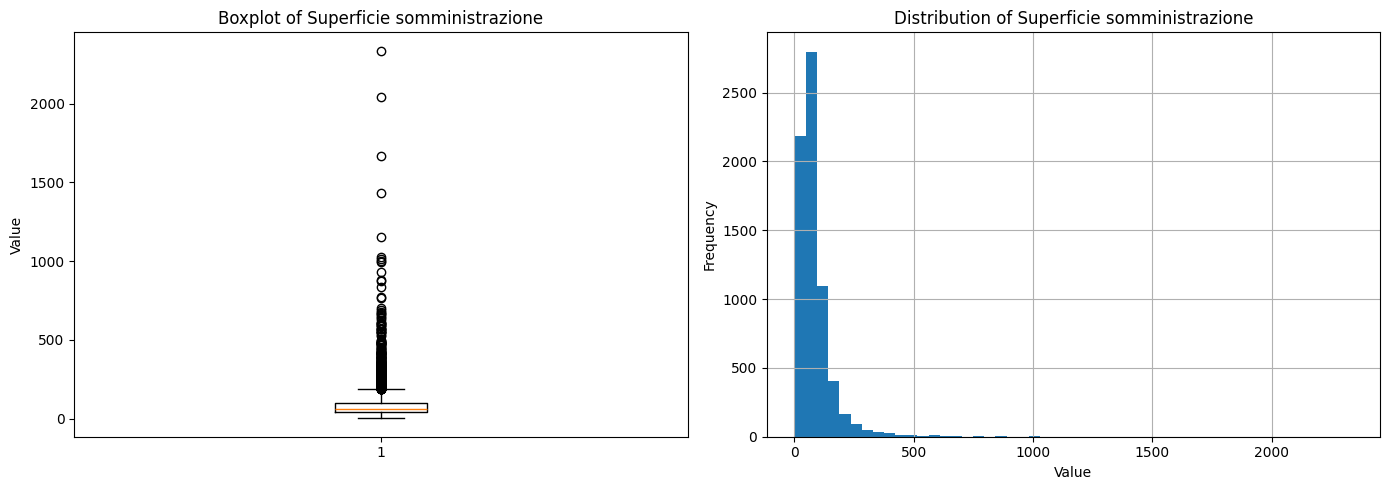

In [21]:
# Boxplot for Superficie somministrazione
sup_col = 'Superficie somministrazione'

if sup_col in MILANO.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    axes[0].boxplot(MILANO[sup_col].dropna())
    axes[0].set_title(f'Boxplot of {sup_col}')
    axes[0].set_ylabel('Value')
    
    # Histogram
    MILANO[sup_col].hist(bins=50, ax=axes[1])
    axes[1].set_title(f'Distribution of {sup_col}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

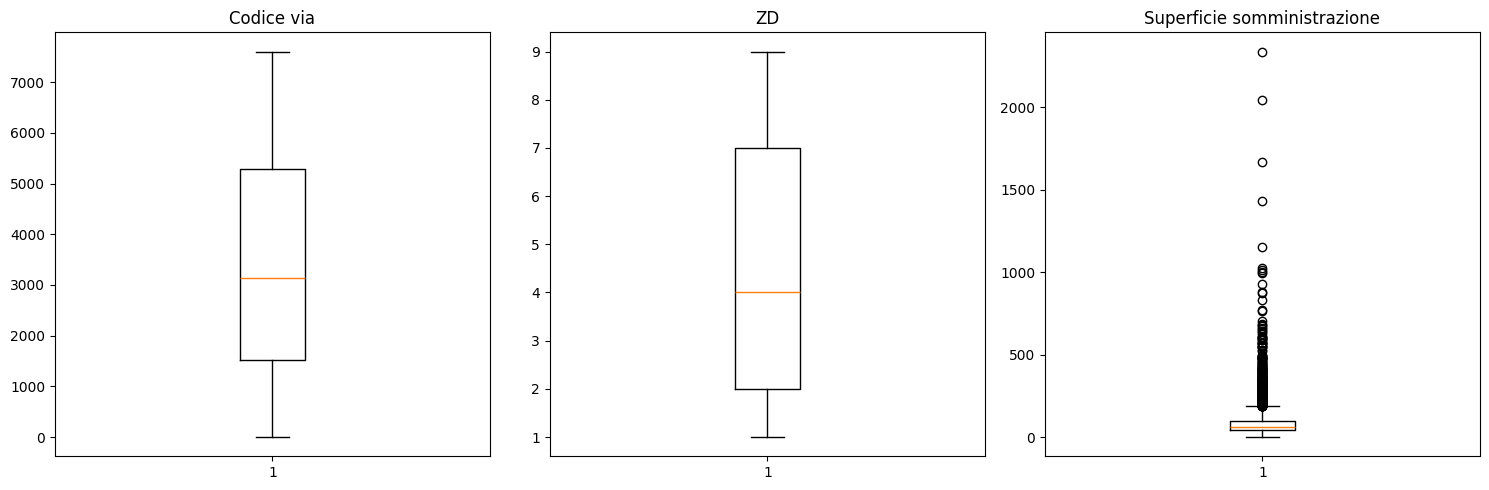

In [22]:
# Boxplots for all numerical columns
if len(NUM) > 0:
    fig, axes = plt.subplots(1, len(NUM), figsize=(5*len(NUM), 5))
    if len(NUM) == 1:
        axes = [axes]
    
    for i, col in enumerate(NUM):
        data = MILANO[col].dropna()
        if len(data) > 0:
            axes[i].boxplot(data)
            axes[i].set_title(col)
    
    plt.tight_layout()
    plt.show()

## 4.5 Z-Score Method for Outlier Detection

In [23]:
from scipy import stats

def detect_outliers_zscore(df, column, threshold=3):
    """Detect outliers using Z-score method."""
    data = df[column].dropna()
    z_scores = np.abs(stats.zscore(data))
    outliers = data[z_scores > threshold]
    
    return {
        'column': column,
        'threshold': threshold,
        'n_outliers': len(outliers),
        'pct_outliers': len(outliers) / len(data) * 100 if len(data) > 0 else 0
    }

In [24]:
# Apply Z-score detection
zscore_summary = []
for col in NUM:
    if MILANO[col].notna().sum() > 0:
        result = detect_outliers_zscore(MILANO, col)
        zscore_summary.append(result)

zscore_df = pd.DataFrame(zscore_summary)
zscore_df

,column,threshold,n_outliers,pct_outliers
0,Codice via,3,0,0.000000
1,ZD,3,0,0.000000
2,Superficie somministrazione,3,103,1.491889


## 4.6 Outlier Handling Strategies

For this dataset, we keep outliers as they may represent legitimate large establishments.

In [25]:
# Flag potential outliers using Z-score method
sup_col = 'Superficie somministrazione'
zscore_threshold = 3

if sup_col in MILANO.columns:
    # Calculate Z-scores
    data = MILANO[sup_col].dropna()
    mean_val = data.mean()
    std_val = data.std()
    
    MILANO['zscore_superficie'] = (MILANO[sup_col] - mean_val) / std_val
    MILANO['is_outlier_superficie'] = np.abs(MILANO['zscore_superficie']) > zscore_threshold
    
    print(f"Outliers flagged (Z-score > {zscore_threshold}): {MILANO['is_outlier_superficie'].sum()}")
    print(f"\nOutlier statistics for {sup_col}:")
    print(f"  Mean: {mean_val:.2f}")
    print(f"  Std: {std_val:.2f}")
    print(f"  Z-score threshold: ±{zscore_threshold}")
    print(f"  Lower bound ({mean_val:.2f} - {zscore_threshold}*{std_val:.2f}): {mean_val - zscore_threshold * std_val:.2f}")
    print(f"  Upper bound ({mean_val:.2f} + {zscore_threshold}*{std_val:.2f}): {mean_val + zscore_threshold * std_val:.2f}")
    
    # Display outlier records
    cols_to_show = [sup_col, 'zscore_superficie', 'Indirizzo', 'ZD']
    if 'Tipo_macro' in MILANO.columns:
        cols_to_show.insert(2, 'Tipo_macro')
    
    outliers_df = MILANO[MILANO['is_outlier_superficie']][cols_to_show].copy()
    outliers_df = outliers_df.sort_values('zscore_superficie', ascending=False)
    
    print(f"\n=== SUPERFICIE SOMMINISTRAZIONE OUTLIERS ({len(outliers_df)} rows) ===")
    display(outliers_df)
    
    # Clean up temporary column
    MILANO = MILANO.drop(columns=['zscore_superficie'])

Outliers flagged (Z-score > 3): 103

Outlier statistics for Superficie somministrazione:
  Mean: 85.98
  Std: 89.26
  Z-score threshold: ±3
  Lower bound (85.98 - 3*89.26): -181.81
  Upper bound (85.98 + 3*89.26): 353.77

=== SUPERFICIE SOMMINISTRAZIONE OUTLIERS (103 rows) ===


,Superficie somministrazione,zscore_superficie,Tipo_macro,Indirizzo,ZD
5529,2336.0,25.206671,RISTORANTE,via washington giorgio n. 66 (interno hotel); ...,7
5602,2041.0,21.901827,RISTORANTE,pza della repubblica n. 17 ; isolato:334; acce...,2
6016,1665.0,17.689553,RISTORANTE,pza della repubblica n. 20 ; isolato:125; acce...,2
5505,1430.0,15.056881,RISTORANTE,via foscolo ugo n. 1 e civico 3;pza del duomo ...,1
5846,1151.0,11.931284,RISTORANTE,via gesu' num.006/8 /8;cso venezia 003; isolat...,1
...,...,...,...,...,...
6675,358.0,3.047417,RISTORANTE,via modica n. 8 ; isolato:045; accesso: access...,6
1603,358.0,3.047417,RISTORANTE,via berra domenico n. 6 con ingr.second. via g...,2
5377,357.0,3.036214,RISTORANTE,via pattari n. 5 c/o hotel con ingresso da via...,1
2846,355.0,3.013809,RISTORANTE,via soresina giovanni battista n. 4 ; isolato:...,7


---
# 5. FINAL SUMMARY AND SAVE

In [26]:
# Final missing values check
null_counts_after = MILANO.isnull().sum()
null_pct_after = (null_counts_after / len(MILANO) * 100).round(2)

final_missing = pd.DataFrame({
    'Column': null_counts_after.index,
    'Missing Count': null_counts_after.values,
    'Missing %': null_pct_after.values
}).sort_values('Missing %', ascending=False)

print("=== FINAL MISSING VALUES STATUS ===")
display(final_missing[final_missing['Missing Count'] > 0])

=== FINAL MISSING VALUES STATUS ===


,Column,Missing Count,Missing %
11,Settore storico pubblico esercizio,21,0.30
8,Forma commercio,1,0.01
9,Forma commercio precedente,1,0.01


In [27]:
# Summary of changes
print("=== CHANGES APPLIED ===")
print("1. Repaired inconsistent Indirizzo field")
print("2. Filled missing Civico from Indirizzo")
print("3. Filled 'Insegna' missing values with 'unknown'")
print("4. Filled 'Superficie somministrazione' missing with mean")
print("5. Imputed 'Forma commercio prev' using macro-category (conf >= 80%)")
print("6. Imputed 'Forma commercio' using 'Forma commercio prev'")
print("7. Created 'Forma vendita_filled' with 'non dichiarata' for missing")
print("8. Flagged surface outliers without removing them")
print(f"\nFinal shape: {MILANO.shape}")

=== CHANGES APPLIED ===
1. Repaired inconsistent Indirizzo field
2. Filled missing Civico from Indirizzo
3. Filled 'Insegna' missing values with 'unknown'
4. Filled 'Superficie somministrazione' missing with mean
5. Imputed 'Forma commercio prev' using macro-category (conf >= 80%)
6. Imputed 'Forma commercio' using 'Forma commercio prev'
7. Created 'Forma vendita_filled' with 'non dichiarata' for missing
8. Flagged surface outliers without removing them

Final shape: (6904, 16)


In [28]:
# Save the cleaned dataset
MILANO.to_csv("MILANO_cleaned.csv", index=False, sep=";")
print("Saved: MILANO_cleaned.csv")

Saved: MILANO_cleaned.csv


In [29]:
# Preview
MILANO.head()

,Tipo esercizio storico pubblico esercizio,Insegna,Indirizzo,Tipo via,Nome via,Civico,Codice via,ZD,Forma commercio,Forma commercio precedente,Forma vendita,Settore storico pubblico esercizio,Superficie somministrazione,Tipo_macro,Forma vendita_filled,is_outlier_superficie
0,ristorante,unknown,alz naviglio grande n. 12 ; isolato:057; (z.d. 6),alz,naviglio grande,12,5144,6,solo somministrazione,somministrazione,al tavolo,"ristorante, trattoria, osteria;genere merceol....",83.0,RISTORANTE,non dichiarata,False
1,bar caffè,unknown,alz naviglio grande n. 44 (z.d. 6),alz,naviglio grande,44,5144,6,solo somministrazione,somministrazione,al banco,bar gastronomici e simili,26.0,BAR,non dichiarata,False
2,bar caffè,unknown,alz naviglio grande n. 48 (z.d. 6),alz,naviglio grande,48,5144,6,solo somministrazione,somministrazione,al banco,bar gastronomici e simili,58.0,BAR,non dichiarata,False
3,"ristorante, trattoria, osteria",unknown,alz naviglio grande n. 8 (z.d. 6),alz,naviglio grande,8,5144,6,solo somministrazione,somministrazione,al tavolo,"bar caffè e simili;ristorante, trattoria, osteria",101.0,RISTORANTE,non dichiarata,False
4,bar caffè,unknown,alz naviglio pavese n. 24 (z.d. 6),alz,naviglio pavese,24,5161,6,solo somministrazione,somministrazione,al banco,bar gastronomici e simili,51.0,BAR,non dichiarata,False
